# Import Modules

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz

from datetime import datetime
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, datasets
from torchmetrics import Accuracy

device = "cuda" if torch.cuda.is_available() else "cpu"

# Dataset

In [2]:
transform = transforms.Compose([
    transforms.Lambda(lambda x: (x / 255) - 0.5),
    # transforms.Resize(size=32)
])

In [3]:
train_dataset = pd.read_csv("../datasets/train.csv")
test_dataset = pd.read_csv("../datasets/test.csv")

X_train = transform(torch.FloatTensor(train_dataset.loc[:, train_dataset.columns != 'label'].to_numpy()))
y_train = torch.LongTensor(train_dataset.label.to_numpy())

X_test = transform(torch.FloatTensor(test_dataset.loc[:, test_dataset.columns != 'label'].to_numpy()))

In [4]:
X_train.shape, y_train.shape

(torch.Size([42000, 784]), torch.Size([42000]))

In [5]:
X_test.shape

torch.Size([28000, 784])

# Tensor Dataset

In [6]:
train_dataset = TensorDataset(X_train, y_train)

# Dataloder

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(train_dataset, batch_size=28000, shuffle=True)

# Model

In [8]:
class CustomModel(nn.Module):
    def __init__(self, width_img, height_img):
        super(CustomModel, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(in_features=width_img * height_img, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=10)
        )
        self.output = nn.Softmax(dim=1)
    
    def forward(self, x):
        x_feature = self.feature(x)
        x_output = self.output(x_feature)
        
        return x_output
    
    def get_feature(self, x):        
        return self.feature[0:4](x)
        
model = CustomModel(28, 28).to(device)
model

CustomModel(
  (feature): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=10, bias=True)
  )
  (output): Softmax(dim=1)
)

# Eval Metric

In [9]:
eval_metric_train = Accuracy().to(device)
eval_metric_test = Accuracy().to(device)
eval_metric_train, eval_metric_test

(Accuracy(), Accuracy())

# Loss Metric

In [10]:
loss_metric = nn.CrossEntropyLoss().to(device)
loss_metric

CrossEntropyLoss()

# Optimizer

In [11]:
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0.01
)

# Training Step

In [12]:
def train_step(dataloader, model, loss_metric, eval_metric, optimizer):
    model.train()
    losses = []
    for batch, (data, actual_labels) in enumerate(train_dataloader, 1):
        data = data.to(device)
        actual_labels = actual_labels.to(device)
        
        # Forward Propagation
        pred_labels = model(data)
        loss = loss_metric(pred_labels, actual_labels)
        metric = eval_metric_train(pred_labels, actual_labels)
        losses.append(loss)
        
        if batch % 50 == 0 or batch == len(train_dataloader):
            print(f"Batch {batch} >> loss: {loss:.3f} | acc: {metric:.3f}")
        
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    mean_loss = torch.mean(torch.tensor(losses))
    mean_metric = eval_metric.compute()
    
    return mean_loss, mean_metric

# Test Step

In [13]:
def test_step(dataloader, model, loss_metric, eval_metric, optimizer):
    model.eval()
    losses = []
    for batch, (data, actual_labels) in enumerate(test_dataloader, 1):
        data = data.to(device)
        actual_labels = actual_labels.to(device)
        
        # Forward Propagation
        pred_labels = model(data)
        loss = loss_metric(pred_labels, actual_labels)
        metric = eval_metric(pred_labels, actual_labels)
        losses.append(loss)
        
        if batch % 50 == 0 or batch == len(test_dataloader):
            print(f"Batch {batch} >> loss: {loss:.3f} | acc: {metric:.3f}")

    mean_loss = torch.mean(torch.tensor(losses))
    mean_metric = eval_metric.compute()
    
    return mean_loss, mean_metric

# Loop Step

In [14]:
def loop_step(n_epoch, early_stopping, train_dataloader, model, loss_metric, eval_metric_train, eval_metric_test, optimizer, device):
    epoch = 1
    n_patience = 0
    train_losses, train_metrics = [], []
    # test_losses, test_metrics = [], []
    
    while True:
        print(f"EPOCH {epoch}")
        print("=" * 40)
        print(f"Train")
        train_loss, train_metric = train_step(train_dataloader, model, loss_metric, eval_metric_train, optimizer)
        train_losses.append(train_loss.to("cpu"))
        train_metrics.append(train_metric.to("cpu"))
        print(f"Average train loss : {train_loss:.3f}")
        print(f"Average train acc  : {train_metric:.3f}\n")
        
        # print(f"Test")
        # test_loss, test_metric = test_step(test_dataloader, model, losseval_metric, eval_metric_test, optimizer)
        # test_losses.append(test_loss)
        # test_metrics.append(test_metric)
        # print(f"Average test loss : {test_loss:.3f}")
        # print(f"Average test acc  : {test_metric:.3f}\n")

        if epoch != 1:
            if train_losses[-1] > train_losses[-2]:
                n_patience += 1
                print(f"Early stopping = {n_patience}! 😔")
            elif train_losses[-1] < train_losses[-2] and n_patience != 0:
                n_patience -= 1
                print(f"Improve! 😄")
            else:
                print(f"Improve! 😄")

            if n_patience == early_stopping:
                print(f"Early stopping = {n_patience}, training stopped!")
                break
                
            # if train_losses[-1] < test_losses[-1]:
            #     print("Model overfit! Training stopped.")
            #     break
        print("=" * 40 + "\n")
        epoch += 1
        eval_metric_train.reset()
        eval_metric_test.reset()
    print("Done!")
    return train_losses, train_metrics

train_losses, train_metrics = loop_step(2, 3, train_dataloader, model, loss_metric, eval_metric_train, eval_metric_test, optimizer, device)

EPOCH 1
Train
Batch 50 >> loss: 1.728 | acc: 0.734
Batch 100 >> loss: 1.656 | acc: 0.828
Batch 150 >> loss: 1.729 | acc: 0.734
Batch 200 >> loss: 1.771 | acc: 0.688
Batch 250 >> loss: 1.692 | acc: 0.781
Batch 300 >> loss: 1.741 | acc: 0.703
Batch 350 >> loss: 1.653 | acc: 0.812
Batch 400 >> loss: 1.548 | acc: 0.938
Batch 450 >> loss: 1.602 | acc: 0.859
Batch 500 >> loss: 1.723 | acc: 0.734
Batch 550 >> loss: 1.566 | acc: 0.906
Batch 600 >> loss: 1.528 | acc: 0.938
Batch 650 >> loss: 1.550 | acc: 0.906
Batch 657 >> loss: 1.542 | acc: 0.875
Average train loss : 1.674
Average train acc  : 0.792


EPOCH 2
Train
Batch 50 >> loss: 1.567 | acc: 0.891
Batch 100 >> loss: 1.498 | acc: 0.969
Batch 150 >> loss: 1.569 | acc: 0.891
Batch 200 >> loss: 1.548 | acc: 0.922
Batch 250 >> loss: 1.530 | acc: 0.938
Batch 300 >> loss: 1.514 | acc: 0.953
Batch 350 >> loss: 1.474 | acc: 1.000
Batch 400 >> loss: 1.547 | acc: 0.922
Batch 450 >> loss: 1.515 | acc: 0.938
Batch 500 >> loss: 1.534 | acc: 0.938
Batch 

# Save Model

In [15]:
now = datetime.now(tz=pytz.timezone("Asia/Makassar"))
now = now.strftime("%m_%d_%Y-%H_%M_%S")

torch.save(model.state_dict(), f"../pretrained_models/{now}.pth")

# Evaluate

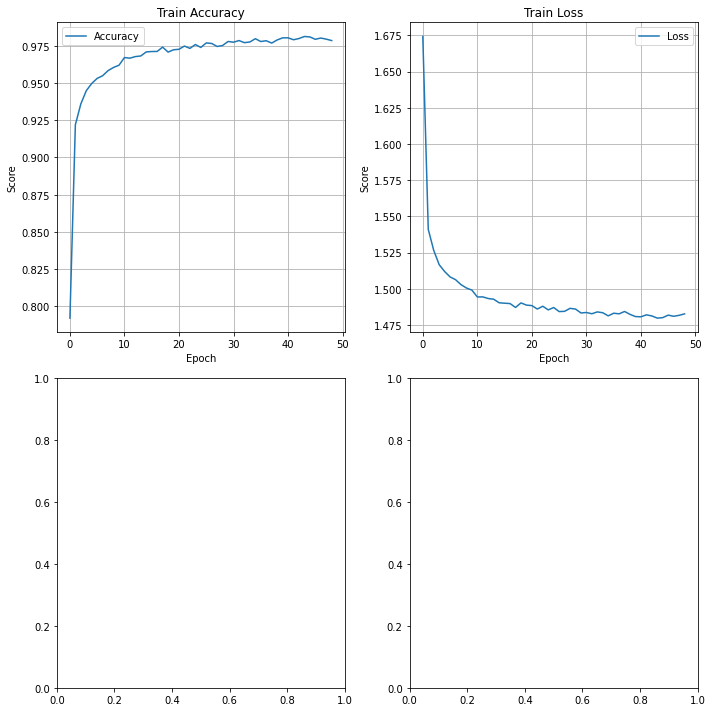

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(10, 10))

ax[0][0].set_title("Train Accuracy")
ax[0][0].plot(train_metrics, label="Accuracy")
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Score")
ax[0][0].grid()
ax[0][0].legend()

ax[0][1].set_title("Train Loss")
ax[0][1].plot(train_losses, label="Loss")
ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Score")
ax[0][1].grid()
ax[0][1].legend();

# ax[1][0].set_title("Train and Test Loss")
# ax[1][0].plot(train_losses, label="Train")
# ax[1][0].plot(test_losses, label="Test")
# ax[1][0].set_xlabel("Epoch")
# ax[1][0].set_ylabel("Score")
# ax[1][0].grid()
# ax[1][0].legend()

# ax[1][1].set_title("Train and Test Accuracy")
# ax[1][1].plot(train_metrics, label="Train")
# ax[1][1].plot(test_metrics, label="Test")
# ax[1][1].set_xlabel("Epoch")
# ax[1][1].set_ylabel("Score")
# ax[1][1].grid()
# ax[1][1].legend();

## X_train

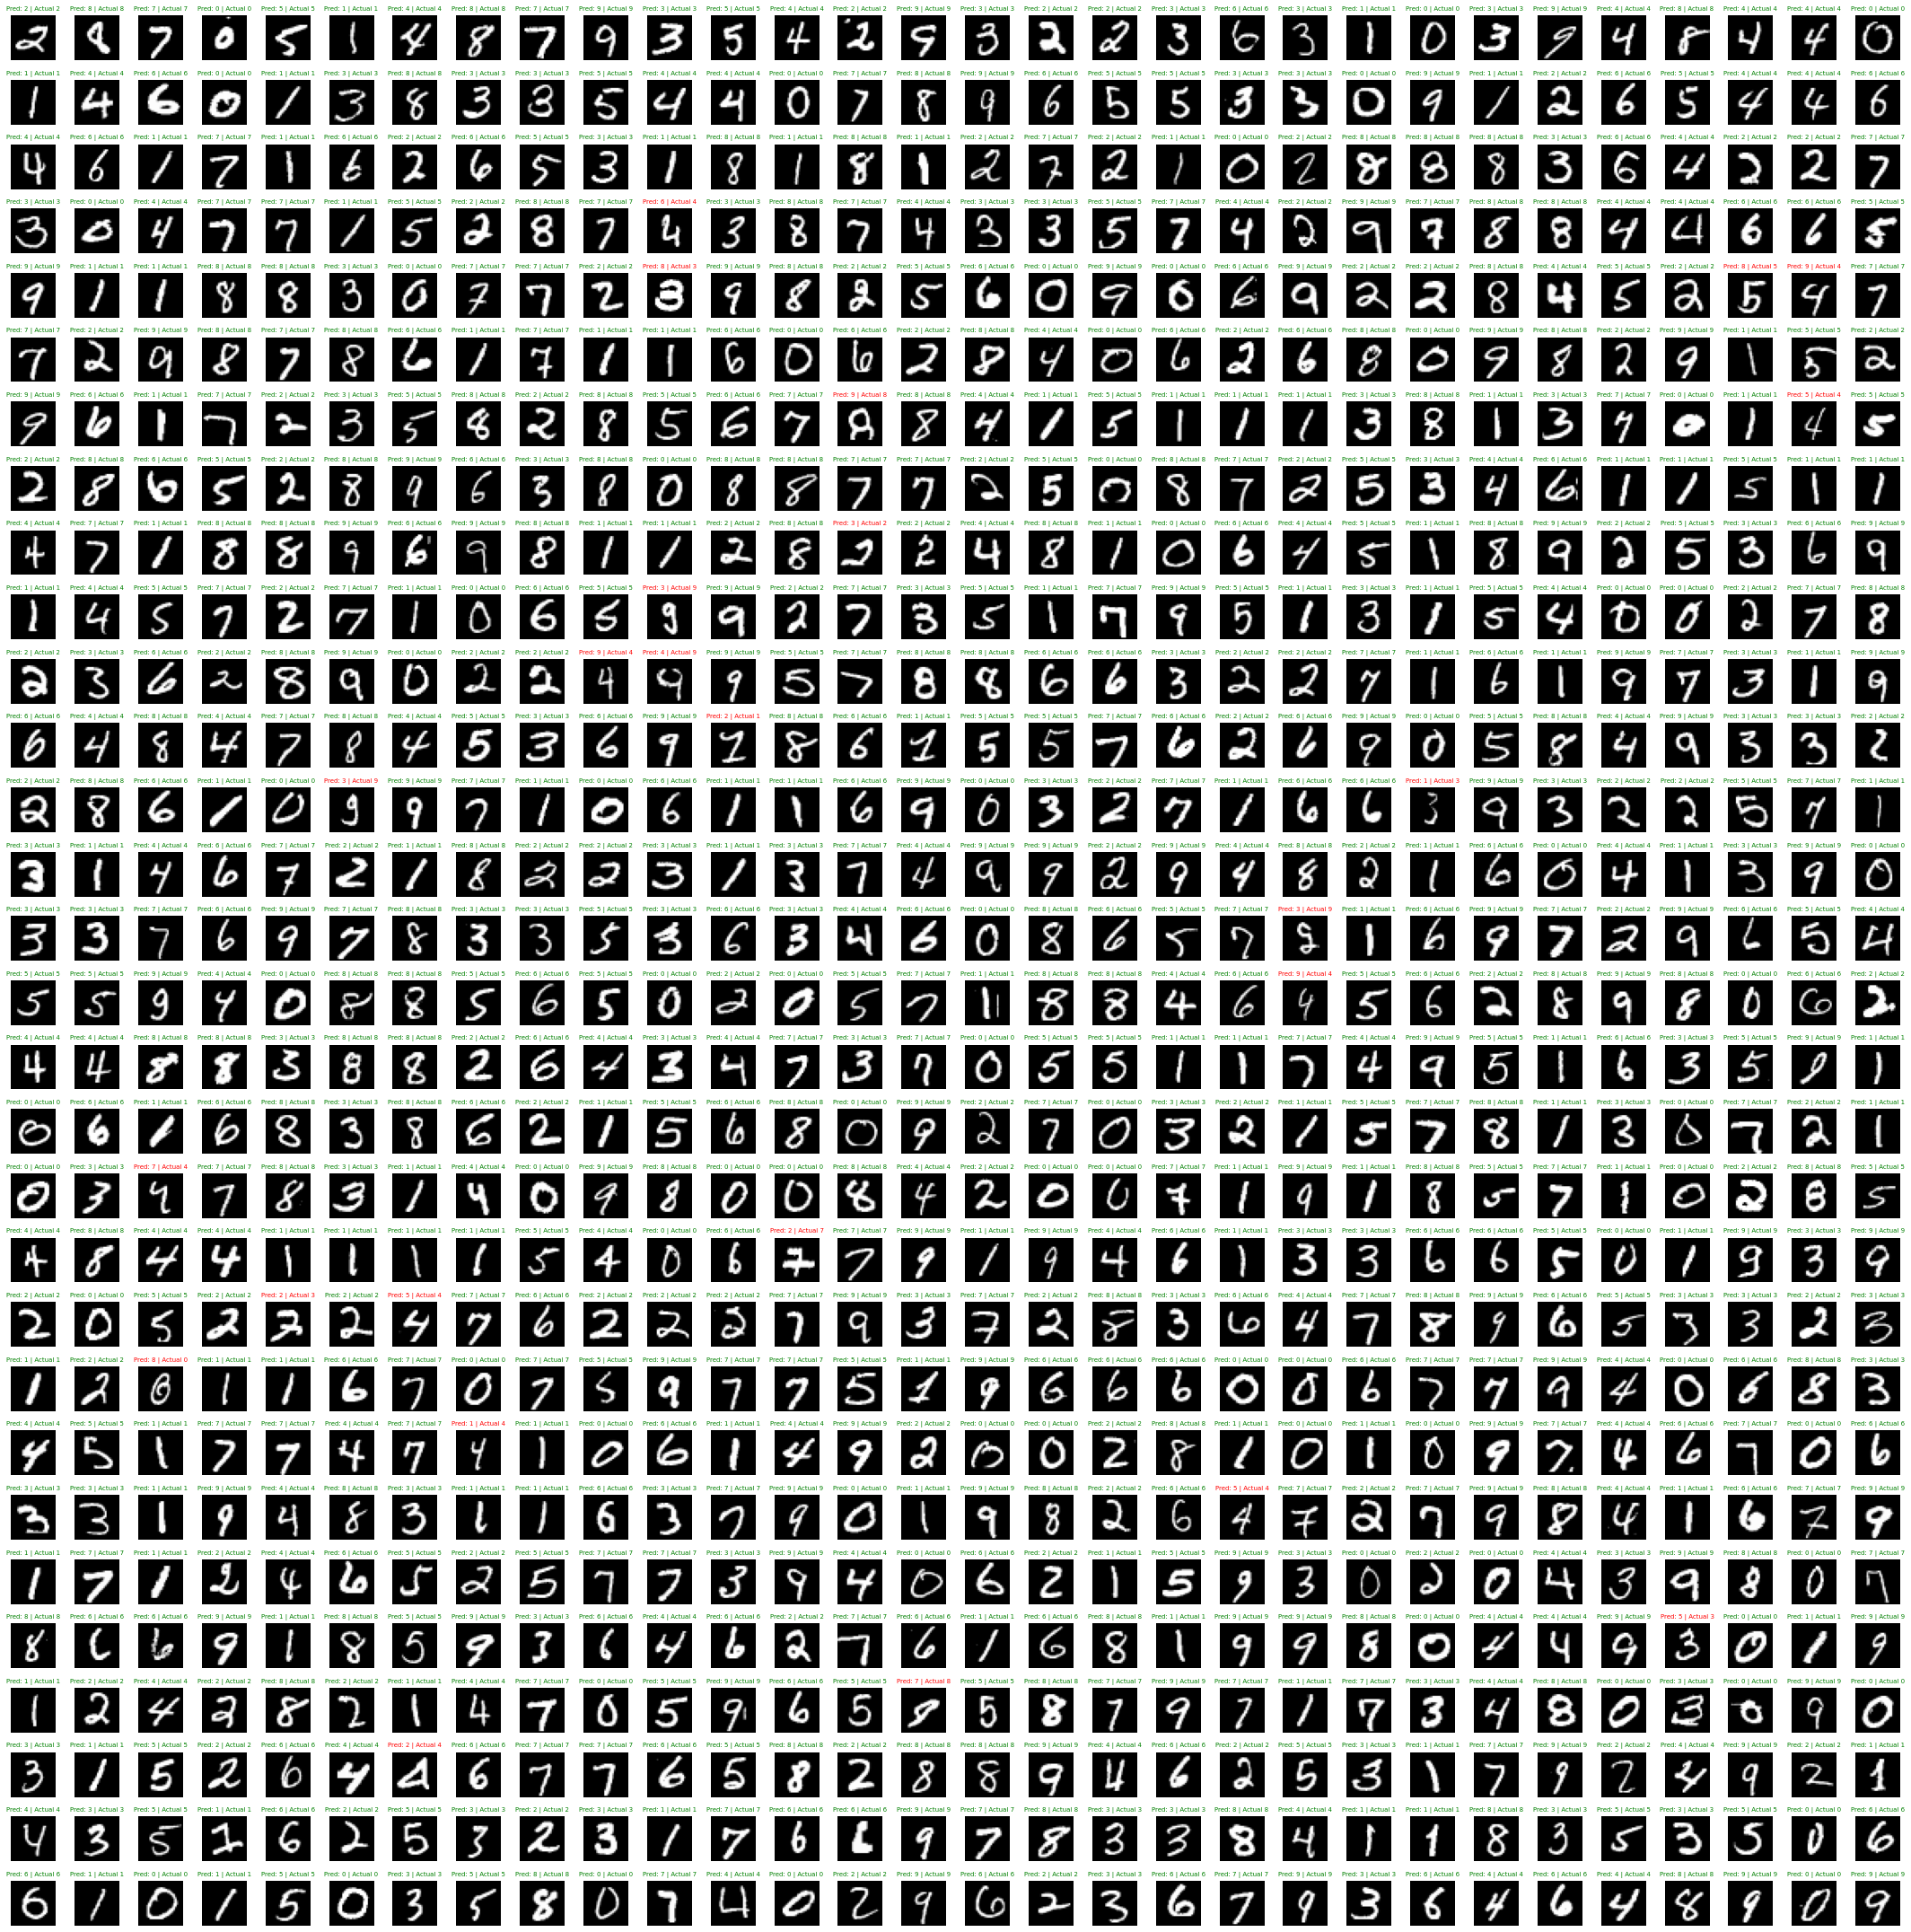

In [17]:
model.eval()
# model.to("cpu")
n_image = 900
idx_start = np.random.randint(0, len(X_test) - 1)
features = X_train[idx_start:idx_start+n_image].to(device)
actual_labels = y_train[idx_start:idx_start+n_image].to(device)
pred_labels = model(features).argmax(1)

plt.figure(figsize=(n_image**0.5, n_image**0.5), tight_layout=True)
for i in range(1, n_image + 1):
    plt.subplot(int(n_image**0.5), int(n_image**0.5), i)
    color_text = "green" if pred_labels[i-1] == actual_labels[i-1] else "red"
    plt.title(f"Pred: {pred_labels[i-1]} | Actual {actual_labels[i-1]}", size=7, color=color_text)
    plt.imshow(features[i-1].reshape((28, 28)).to("cpu"), cmap=plt.cm.gray)
    plt.axis("off")
plt.savefig(f"../callbacks/images/{now}_X_train_prediction.jpeg", dpi=100)

## X_test

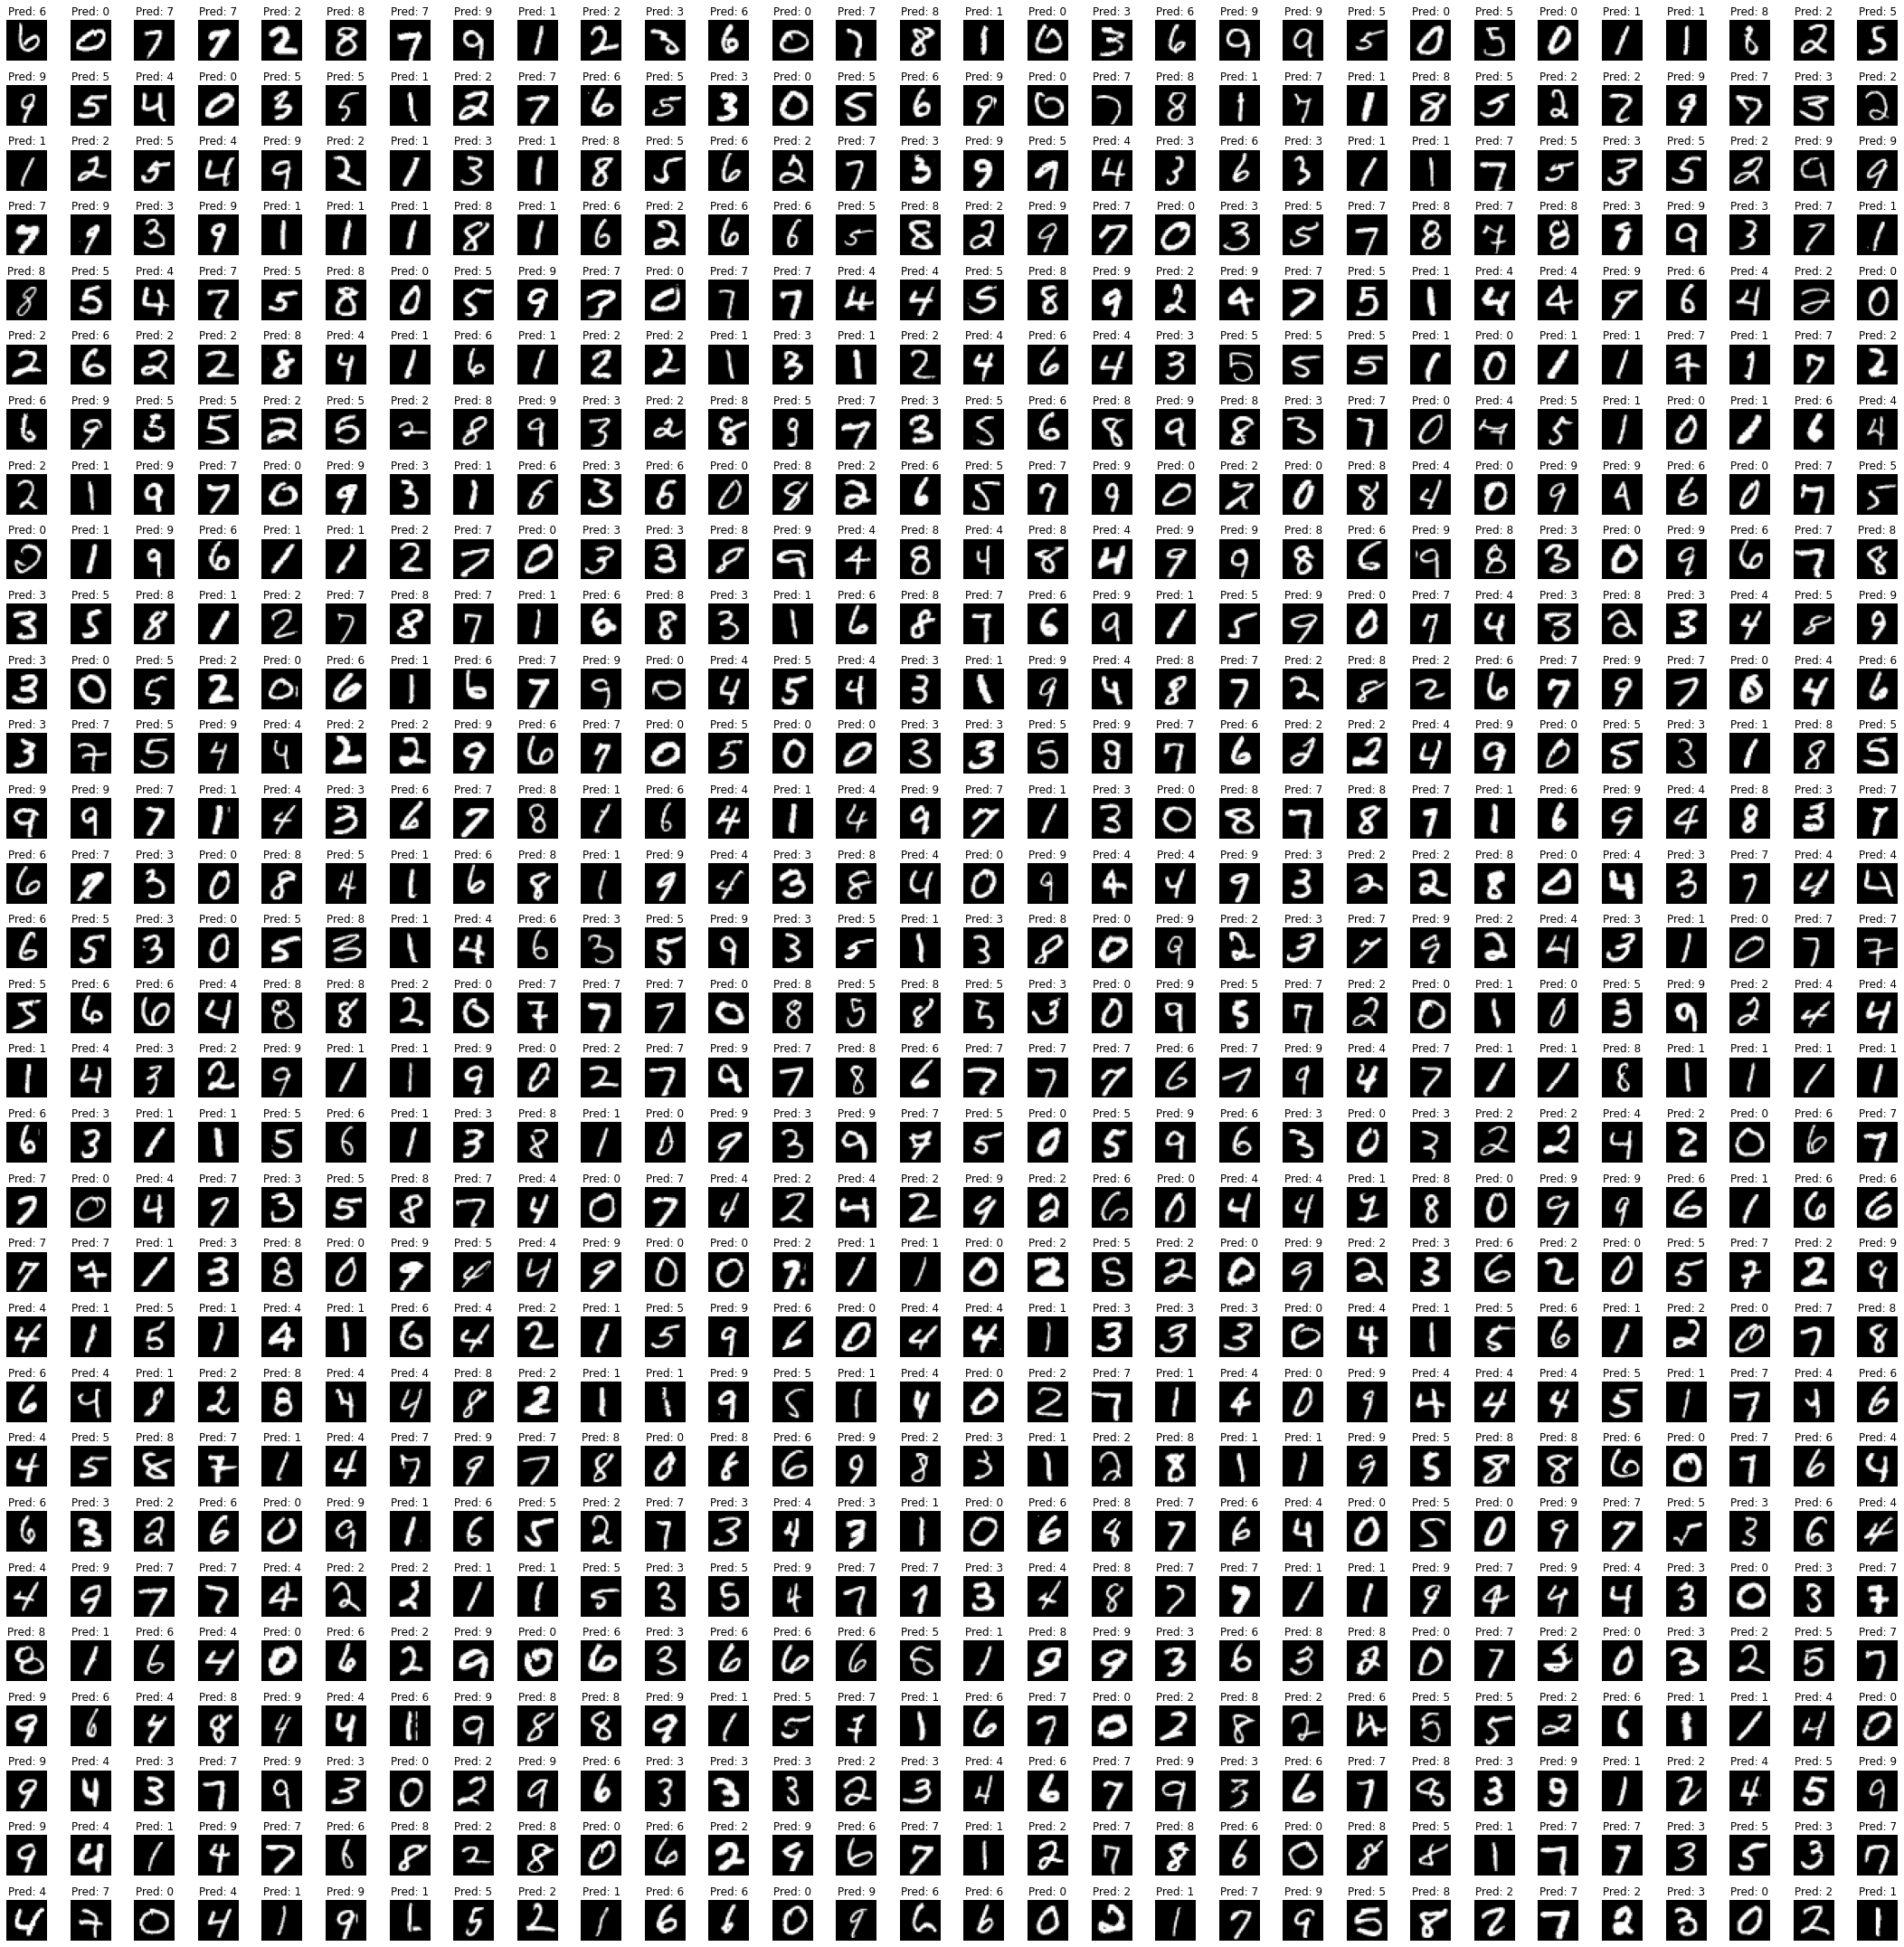

In [18]:
model.eval()
n_image = 900
idx_start = np.random.randint(0, len(X_test) - 1)
features = X_test[idx_start:idx_start+n_image].to(device)
pred_labels = model(features).argmax(1)

plt.figure(figsize=(n_image**0.5, n_image**0.5), tight_layout=True)
for i in range(1, n_image + 1):
    plt.subplot(int(n_image**0.5), int(n_image**0.5), i)
    plt.title(f"Pred: {pred_labels[i-1]}", color="black")
    plt.imshow(features[i-1].reshape((28, 28)).to("cpu"), cmap=plt.cm.gray)
    plt.axis("off")
plt.savefig(f"../callbacks/images/{now}_X_test_prediction.jpeg", dpi=100)

# Predict

In [19]:
pred_labels = model(X_test.to(device)).argmax(1)
submission_df = pd.DataFrame({
    "ImageId": np.arange(1, 28001),
    "Label": pred_labels.to("cpu")
})

submission_df.to_csv(f"../submissions/{now}.csv", index=False)